# Natural Language Processing - Text Classification example

###### Links: [News dataset (Kaggle)](https://www.kaggle.com/rmisra/news-category-dataset)  |  [Article 1 (TowardsDataScience)](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d) |  [Article 2 (TowardsDataScience)](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) | [Article 3 (TowardsDataScience)](https://towardsdatascience.com/text-classification-with-no-model-training-935fe0e42180)

### 0 - Setup

###### Import pckgs

In [4]:
import warnings
warnings.filterwarnings("ignore")
from nlp_utils import *

###### Import data

In [181]:
import json

lst_dics = []
with open('data_news.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [182]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
dtf = dtf.rename(columns={"category":"y", "headline":"text"})

In [4]:
dtf.sample(5)

y                                               text
139112           TECH               A Funeral for Online Appropriateness
27617        POLITICS  Texas Voter ID Law Led To Fears And Failures I...
100565       POLITICS      GOP Eyes Abolishing Supreme Court Filibusters
118937  ENTERTAINMENT            Eminem's Daughter Graduates High School
81338        POLITICS  McConnell Admits Republicans Don't Have The Vo...

In [4]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
y       50879 non-null object
text    50879 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


### 1 - Text Analysis

###### Look for Metadata
- Language detection
- Named-entities recognition
- Text cleaning
- Length analysis
- Sentiment analysis
- Word frequency

###### Target Variable

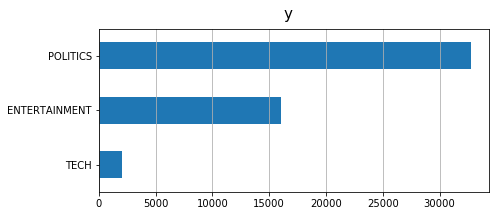

In [6]:
plot_distributions(dtf, x="y", top=None, figsize=(7,3))

In [7]:
# Imbalanced

###### Language Detection

In [183]:
# this takes a while
dtf = add_detect_lang(dtf, "text")
dtf.head()

y                                               text lang
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en

In [5]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["lang"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  en


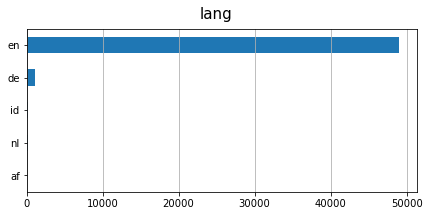

In [6]:
plot_distributions(dtf, x="lang", top=5, figsize=(7,3))

In [184]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]

###### Named-Entity Recognition

In [8]:
ner = spacy.load("en_core_web_lg")

In [9]:
lst_tag_type = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]

In [10]:
ner_displacy(dtf["text"].iloc[0], ner, lst_tag_type, title="NER example")

In [11]:
# example of replacing text and tags extraction
utils_ner_text(dtf["text"].iloc[0], ner, lst_tag_type, grams_join="_")

("Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song",
 [('Will Smith', 'PERSON'),
  ('Diplo', 'PERSON'),
  ('Nicky Jam', 'PERSON'),
  ("The 2018 World Cup's", 'EVENT')])

In [12]:
# this takes a while
dtf = add_ner_spacy(dtf, "text", ner, lst_tag_type, grams_join="_", create_features=True)
dtf.head()

--- tagging ---
--- counting tags ---
--- creating features ---


y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                         text_tagged  \
1  Will_Smith Joins Diplo And Nicky_Jam For The_2...   
2    Hugh_Grant_Marries For The First Time At Age 57   
3  Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...   
4  Julianna_Margulies Uses Donald Trump Poop Bags...   
5  Morgan_Freeman_'Devastated' That Sexual Harass...   

                                                tags  tags_LOC  tags_NORP  \
1  [{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...         0          0   
2            [{('Hugh Grant Marries', 'PERSON'): 1}]         0          0   
3  [{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...         0          1   
4            [{('Julianna Margulies', 'PERSON'): 1}]         0          0   
5                 [{('Morgan Freeman '', 'ORG'): 1}]         0          0   

   tags_PRODUCT  tags_WORK_OF_ART  tags_GPE  tags_ORG  tags_EVENT  \
1             0                 0         0         0           1   
2             0                 0         0         0           0   
3             0                 0         0         0           0   
4             0                 0         0         0           0   
5             0                 0         0         1           0   

   tags_PERSON  tags_FAC  
1            3         0  
2            1         0  
3            2         0  
4            1         0  
5            0         0

In [17]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_tagged"].iloc[i])
print("tags:")
dtf["tags"].iloc[i]

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song
tags:


[{('Will Smith', 'PERSON'): 1},
 {('Diplo', 'PERSON'): 1},
 {('Nicky Jam', 'PERSON'): 1},
 {("The 2018 World Cup's", 'EVENT'): 1}]

# ENTERTAINMENT:


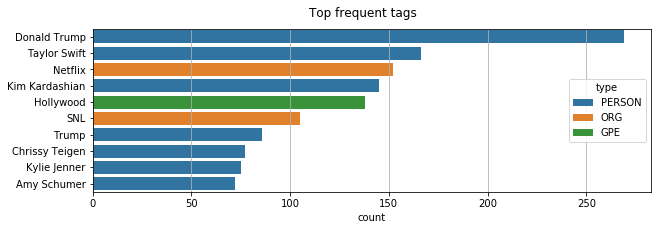

# POLITICS:


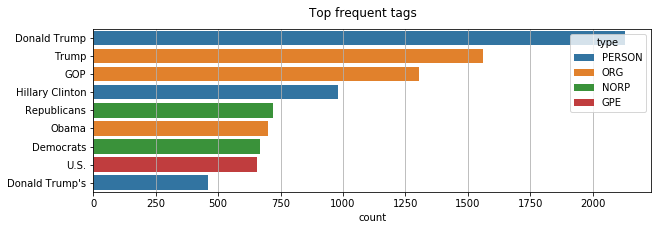

# TECH:


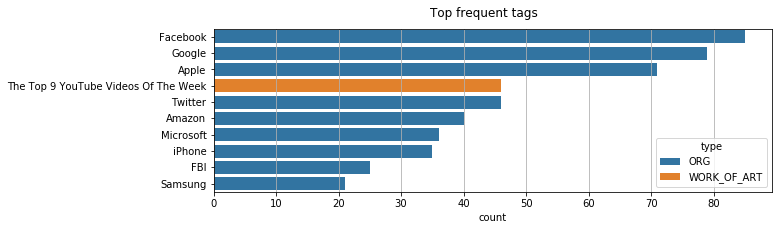

In [18]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    common_tags = tags_freq(tags=dtf[dtf["y"]==y]["tags"], top=10, figsize=(10,3))

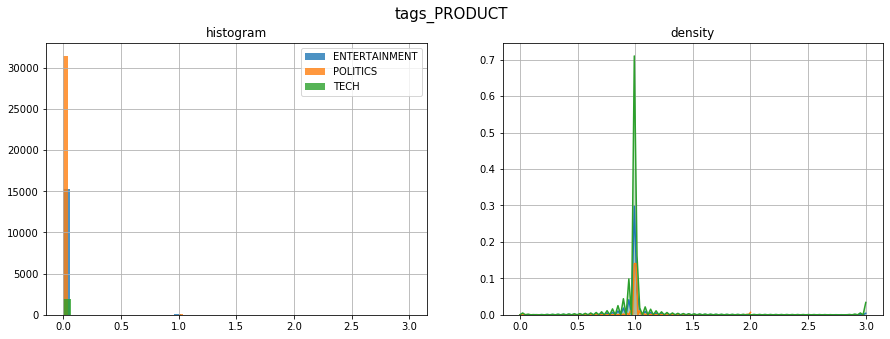

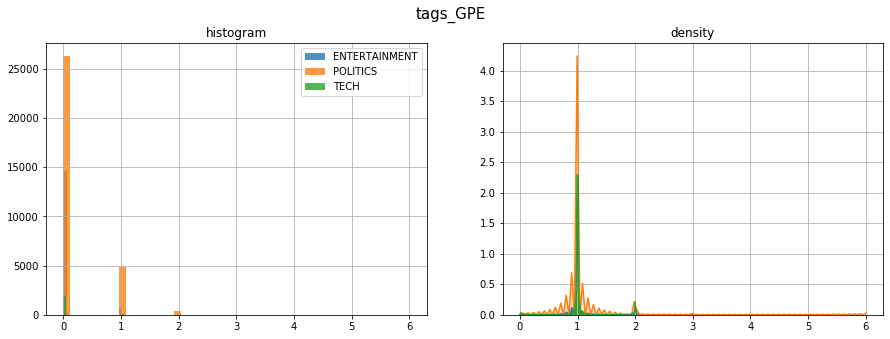

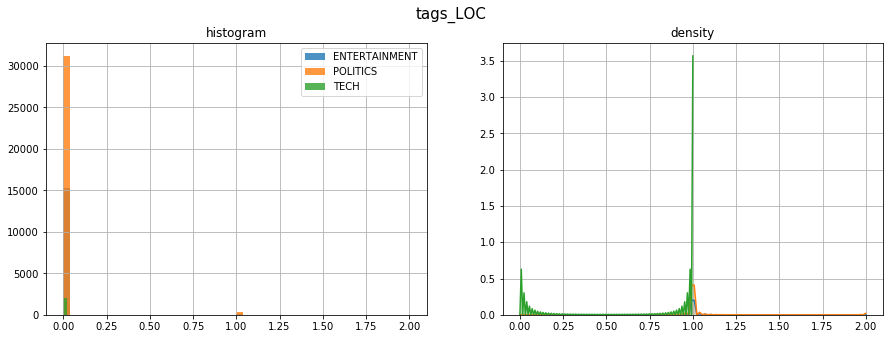

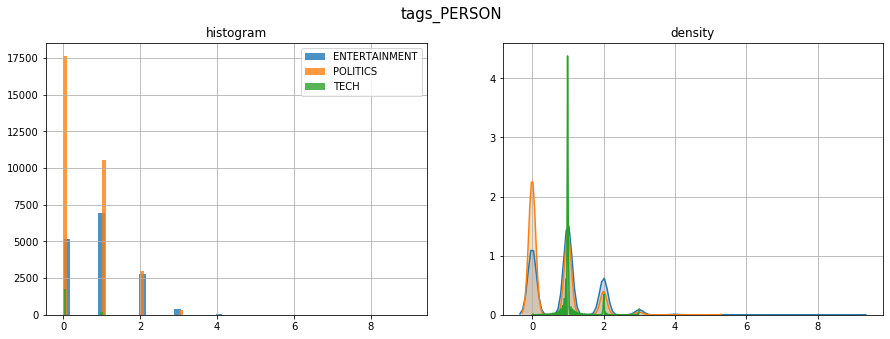

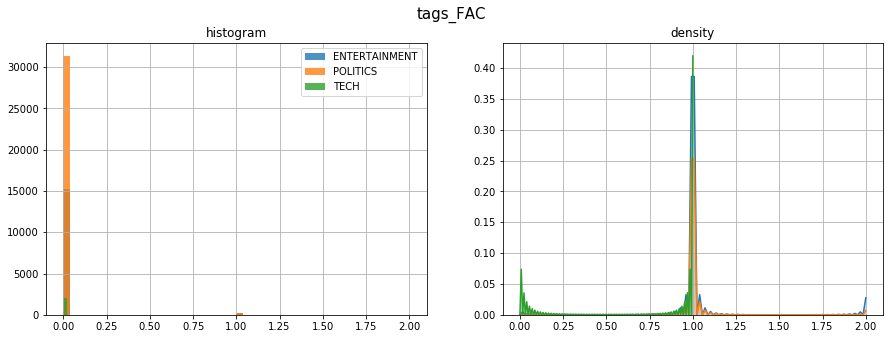

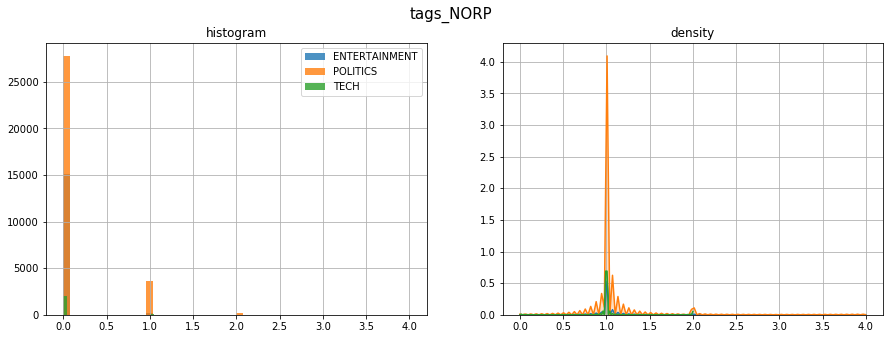

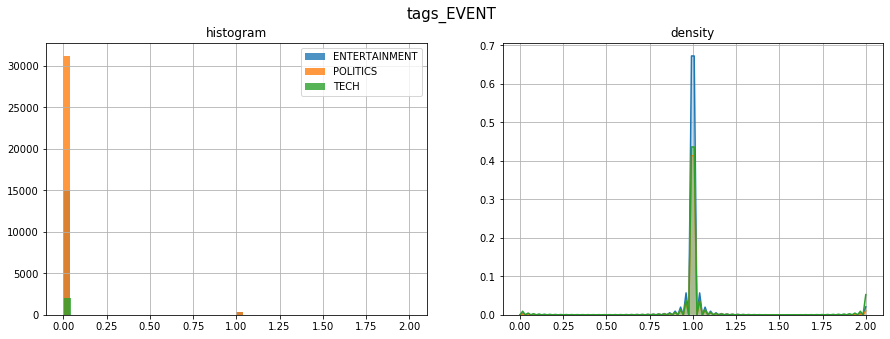

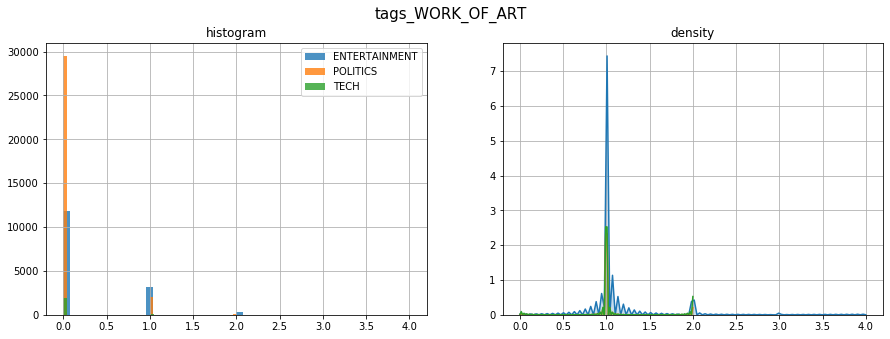

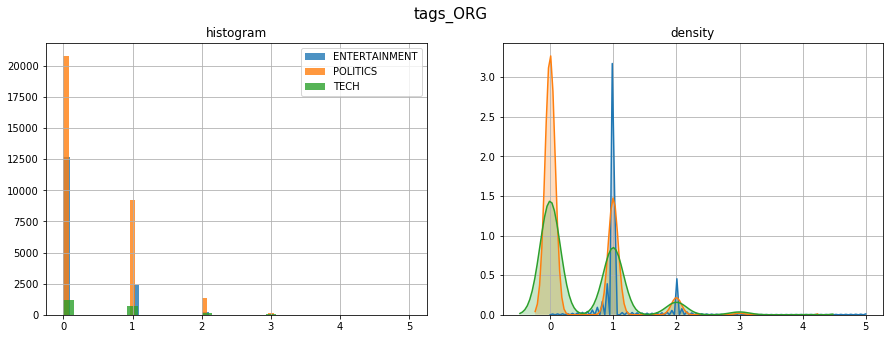

In [19]:
# tags bivariate distribution
for x in dtf.filter(like="tags_", axis=1).columns:
    plot_distributions(dtf, x=x, y="y", bins=None, figsize=(15,5))

###### Text Cleaning

In [13]:
# example
i = 0
print("--- original ---")
print(dtf["text"].iloc[i])

print("--- cleaning ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=None, flg_stemm=False, flg_lemm=True))

print("--- tokenization ---")
print(dtf["text"].iloc[i].split())

print("--- remove stopwords ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=False, flg_lemm=None))

print("--- stemming ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=True, flg_lemm=False))

print("--- lemmatisation ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=False, flg_lemm=True))

--- original ---
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
--- cleaning ---
will smith join diplo and nicky jam for the 2018 world cup official song
--- tokenization ---
['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']
--- remove stopwords ---
smith joins diplo nicky jam 2018 world cups official song
--- stemming ---
smith join diplo nicki jam 2018 world cup offici song
--- lemmatisation ---
smith join diplo nicky jam 2018 world cup official song


In [185]:
# create stopwords
lst_stopwords = create_stopwords(["english"], 
                                 lst_add_words=["dtype","say","new","length","object","u","ha","wa"],
                                 lst_keep_words=["new"])
lst_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'dtype',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'ha',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'length',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'object',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'say',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'u',
 'under',
 'until',
 'up',
 've',
 'very',
 'wa',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves']

In [186]:
# preprocess text
dtf = add_preprocessed_text(dtf, "text", lst_regex=None, lst_stopwords=lst_stopwords, flg_stemm=False, flg_lemm=True)
dtf.head()

--- found NAs ---
                               text text_clean
10904                      What If?           
31850   This Is Us Is For All Of Us           
92381             WHO Are You Now ?           
121299                 So Now What?           


y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                          text_clean  
1  smith join diplo nicky jam 2018 world cup offi...  
2               hugh grant marries first time age 57  
3  jim carrey blast castrato adam schiff democrat...  
4  julianna margulies us donald trump poop bag pi...  
5  morgan freeman devastated sexual harassment cl...

In [16]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_clean"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
smith join diplo nicky jam 2018 world cup official song


###### Length Analysis

In [17]:
dtf = add_text_length(dtf, "text_clean")
dtf.head()

                     min       mean    max
word_count           1.0   7.388294   36.0
char_count           4.0  43.621021  214.0
sentence_count       1.0   1.000000    1.0
avg_word_length      2.5   5.952326   15.0
avg_sentence_lenght  1.0   7.388294   36.0


y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                         text_tagged  \
1  Will_Smith Joins Diplo And Nicky_Jam For The_2...   
2    Hugh_Grant_Marries For The First Time At Age 57   
3  Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...   
4  Julianna_Margulies Uses Donald Trump Poop Bags...   
5  Morgan_Freeman_'Devastated' That Sexual Harass...   

                                                tags  tags_LOC  tags_NORP  \
1  [{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...         0          0   
2            [{('Hugh Grant Marries', 'PERSON'): 1}]         0          0   
3  [{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...         0          1   
4            [{('Julianna Margulies', 'PERSON'): 1}]         0          0   
5                 [{('Morgan Freeman '', 'ORG'): 1}]         0          0   

   tags_PRODUCT  tags_WORK_OF_ART  tags_GPE  tags_ORG  tags_EVENT  \
1             0                 0         0         0           1   
2             0                 0         0         0           0   
3             0                 0         0         0           0   
4             0                 0         0         0           0   
5             0                 0         0         1           0   

   tags_PERSON  tags_FAC                                         text_clean  \
1            3         0  smith join diplo nicky jam 2018 world cup offi...   
2            1         0               hugh grant marries first time age 57   
3            2         0  jim carrey blast castrato adam schiff democrat...   
4            1         0  julianna margulies us donald trump poop bag pi...   
5            0         0  morgan freeman devastated sexual harassment cl...   

   word_count  char_count  sentence_count  avg_word_length  \
1          10          46               1         4.600000   
2           7          30               1         4.285714   
3           9          50               1         5.555556   
4           9          44               1         4.888889   
5           9          64               1         7.111111   

   avg_sentence_lenght  
1                 10.0  
2                  7.0  
3                  9.0  
4                  9.0  
5                  9.0

In [18]:
# check
i = 0
print(dtf["text_clean"].iloc[i], " --> ")
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    print(col+":", dtf[col].iloc[i])

smith join diplo nicky jam 2018 world cup official song  --> 
word_count: 10
char_count: 46
sentence_count: 1
avg_word_length: 4.6
avg_sentence_lenght: 10.0


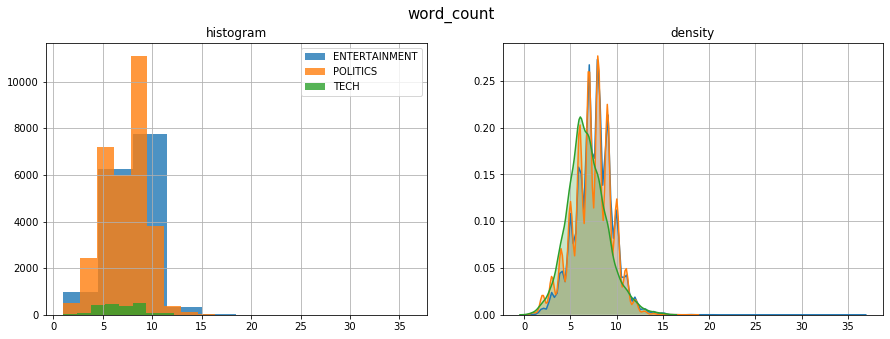

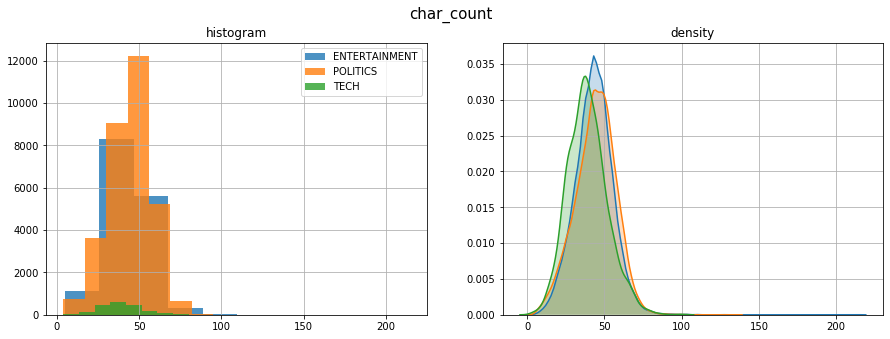

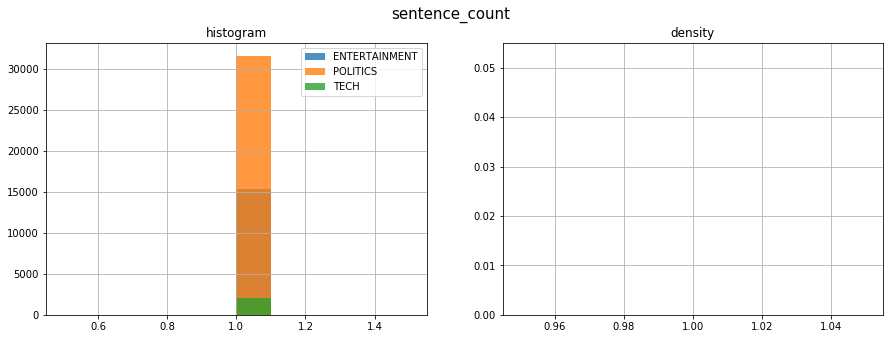

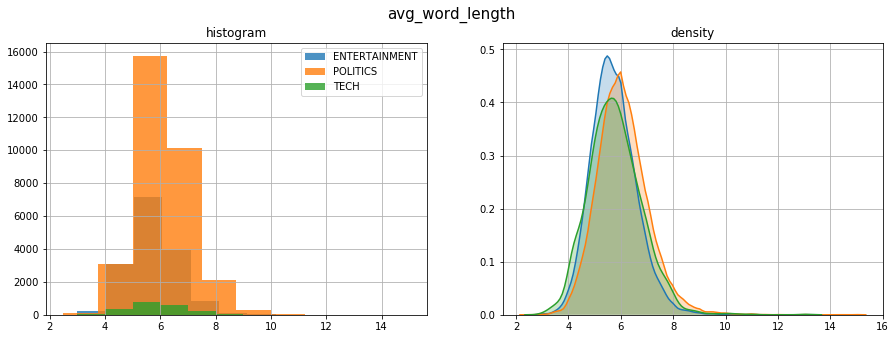

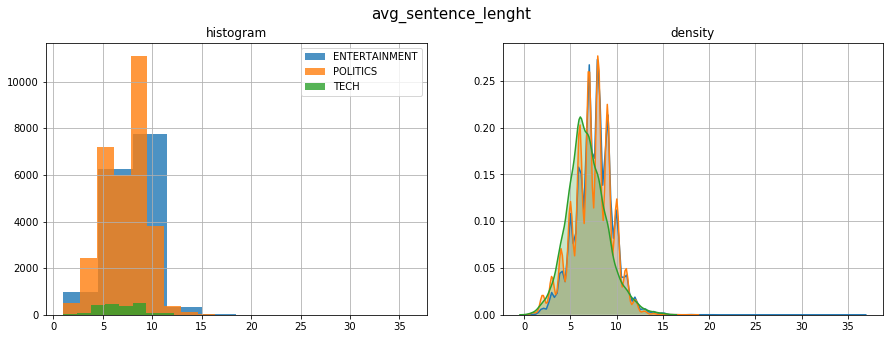

In [19]:
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    plot_distributions(dtf, x=col, y="y", bins=10, figsize=(15,5))

###### Sentiment Analysis

In [20]:
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(-1,1))
dtf.head()

             count      mean       std  min  25%  50%  75%  max
sentiment  48950.0  0.042757  0.257777 -1.0  0.0  0.0  0.1  1.0


y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                         text_tagged  \
1  Will_Smith Joins Diplo And Nicky_Jam For The_2...   
2    Hugh_Grant_Marries For The First Time At Age 57   
3  Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...   
4  Julianna_Margulies Uses Donald Trump Poop Bags...   
5  Morgan_Freeman_'Devastated' That Sexual Harass...   

                                                tags  tags_LOC  tags_NORP  \
1  [{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...         0          0   
2            [{('Hugh Grant Marries', 'PERSON'): 1}]         0          0   
3  [{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...         0          1   
4            [{('Julianna Margulies', 'PERSON'): 1}]         0          0   
5                 [{('Morgan Freeman '', 'ORG'): 1}]         0          0   

   tags_PRODUCT  tags_WORK_OF_ART  tags_GPE  ...  tags_EVENT  tags_PERSON  \
1             0                 0         0  ...           1            3   
2             0                 0         0  ...           0            1   
3             0                 0         0  ...           0            2   
4             0                 0         0  ...           0            1   
5             0                 0         0  ...           0            0   

   tags_FAC                                         text_clean word_count  \
1         0  smith join diplo nicky jam 2018 world cup offi...         10   
2         0               hugh grant marries first time age 57          7   
3         0  jim carrey blast castrato adam schiff democrat...          9   
4         0  julianna margulies us donald trump poop bag pi...          9   
5         0  morgan freeman devastated sexual harassment cl...          9   

   char_count  sentence_count  avg_word_length  avg_sentence_lenght  sentiment  
1          46               1         4.600000                 10.0   0.000000  
2          30               1         4.285714                  7.0   0.250000  
3          50               1         5.555556                  9.0   0.136364  
4          44               1         4.888889                  9.0   0.000000  
5          64               1         7.111111                  9.0   0.500000  

[5 rows x 21 columns]

In [21]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["sentiment"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  0.0


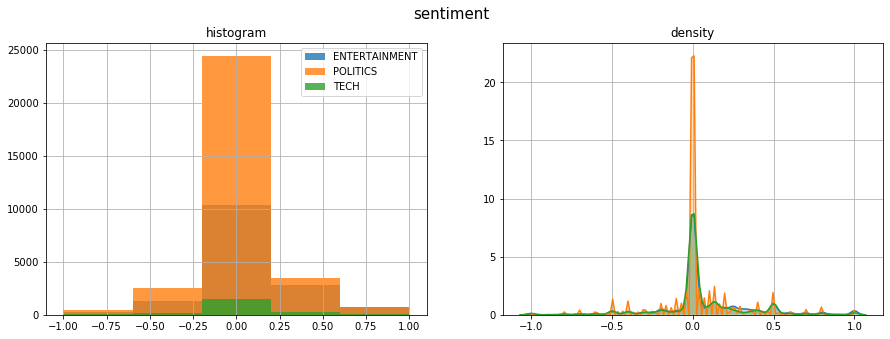

In [22]:
plot_distributions(dtf, x="sentiment", y="y", bins=5, figsize=(15,5))

In [23]:
# I'll give a range of 0-1 to the sentiment
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(0,1))

             count      mean       std  min  25%  50%   75%  max
sentiment  48950.0  0.521378  0.128888  0.0  0.5  0.5  0.55  1.0


###### Word frequency

# ENTERTAINMENT:


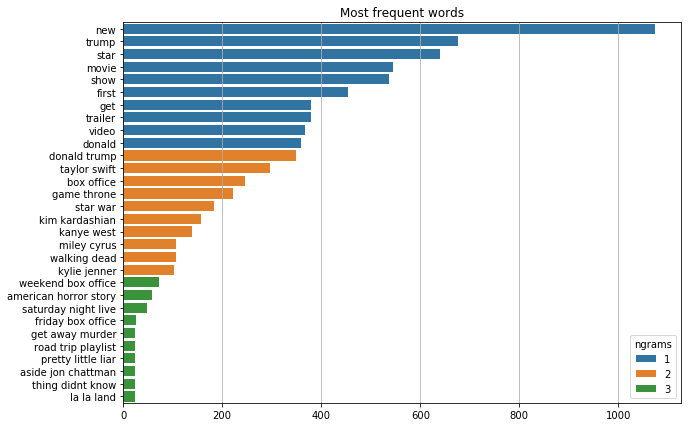

# POLITICS:


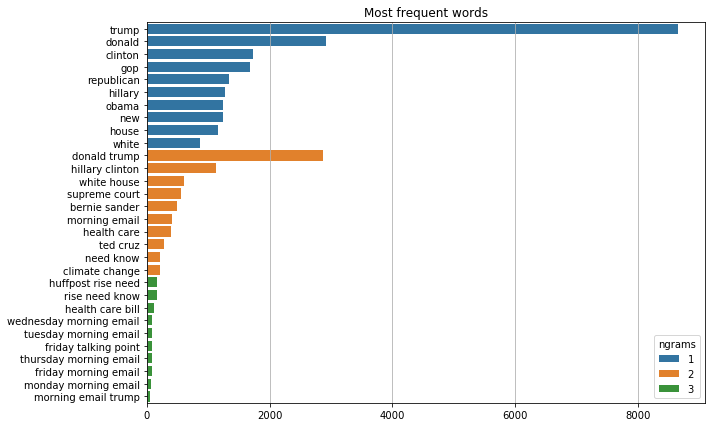

# TECH:


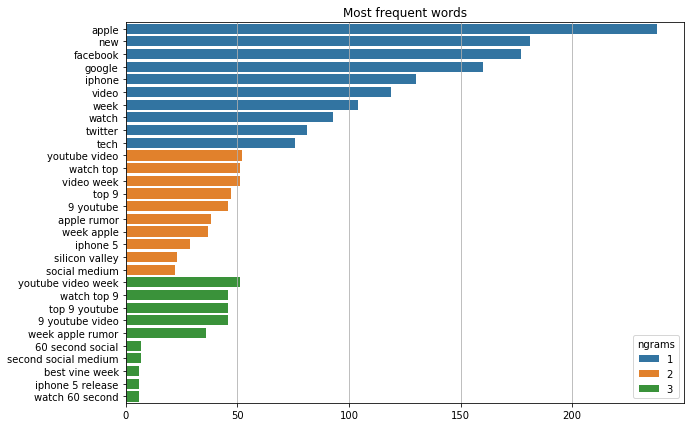

In [24]:
dtf_freq = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [32]:
dtf_freq.sample(5)

word  freq  ngrams              y
77978      member congress vote     1       3       POLITICS
43341     billion key obamacare     1       3       POLITICS
3612               poehler park     2       2  ENTERTAINMENT
46805          timberlake chloë     1       2  ENTERTAINMENT
26053  exgirlfriend stevie ryan     1       3  ENTERTAINMENT

# ENTERTAINMENT:


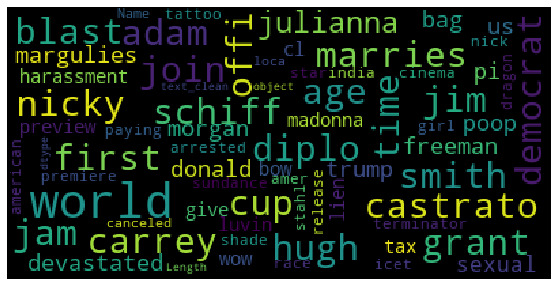

# POLITICS:


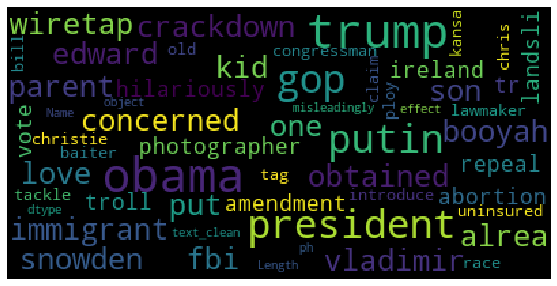

# TECH:


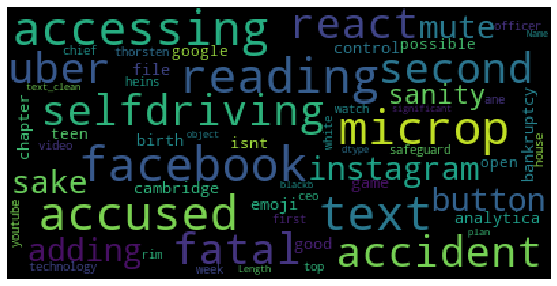

In [26]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=dtf[dtf["y"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

In [51]:
# add specific words as features
dtf = add_word_freq(dtf, "text_clean", lst_words=["new york","new","york"], freq="count")
dtf.head()

found records:
['new york: 299', 'new: 3160', 'york: 301']


y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                         text_tagged  \
1  Will_Smith Joins Diplo And Nicky_Jam For The_2...   
2    Hugh_Grant_Marries For The First Time At Age 57   
3  Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...   
4  Julianna_Margulies Uses Donald Trump Poop Bags...   
5  Morgan_Freeman_'Devastated' That Sexual Harass...   

                                                tags  tags_LOC  tags_NORP  \
1  [{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...         0          0   
2            [{('Hugh Grant Marries', 'PERSON'): 1}]         0          0   
3  [{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...         0          1   
4            [{('Julianna Margulies', 'PERSON'): 1}]         0          0   
5                 [{('Morgan Freeman '', 'ORG'): 1}]         0          0   

   tags_PRODUCT  tags_WORK_OF_ART  tags_GPE  ...  \
1             0                 0         0  ...   
2             0                 0         0  ...   
3             0                 0         0  ...   
4             0                 0         0  ...   
5             0                 0         0  ...   

                                          text_clean  word_count  char_count  \
1  smith join diplo nicky jam 2018 world cup offi...          10          46   
2               hugh grant marries first time age 57           7          30   
3  jim carrey blast castrato adam schiff democrat...           9          50   
4  julianna margulies us donald trump poop bag pi...           9          44   
5  morgan freeman devastated sexual harassment cl...           9          64   

   sentence_count avg_word_length  avg_sentence_lenght  sentiment  new york  \
1               1        4.600000                 10.0   0.500000       0.0   
2               1        4.285714                  7.0   0.625000       0.0   
3               1        5.555556                  9.0   0.568182       0.0   
4               1        4.888889                  9.0   0.500000       0.0   
5               1        7.111111                  9.0   0.750000       0.0   

   new  york  
1  0.0   0.0  
2  1.0   0.0  
3  0.0   0.0  
4  0.0   0.0  
5  1.0   0.0  

[5 rows x 24 columns]

###### Summary

In [52]:
# keeping all the features
dtf.head()

y                                               text lang  \
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   en   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   en   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   en   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   en   
5  ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...   en   

                                         text_tagged  \
1  Will_Smith Joins Diplo And Nicky_Jam For The_2...   
2    Hugh_Grant_Marries For The First Time At Age 57   
3  Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...   
4  Julianna_Margulies Uses Donald Trump Poop Bags...   
5  Morgan_Freeman_'Devastated' That Sexual Harass...   

                                                tags  tags_LOC  tags_NORP  \
1  [{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...         0          0   
2            [{('Hugh Grant Marries', 'PERSON'): 1}]         0          0   
3  [{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...         0          1   
4            [{('Julianna Margulies', 'PERSON'): 1}]         0          0   
5                 [{('Morgan Freeman '', 'ORG'): 1}]         0          0   

   tags_PRODUCT  tags_WORK_OF_ART  tags_GPE  ...  \
1             0                 0         0  ...   
2             0                 0         0  ...   
3             0                 0         0  ...   
4             0                 0         0  ...   
5             0                 0         0  ...   

                                          text_clean  word_count  char_count  \
1  smith join diplo nicky jam 2018 world cup offi...          10          46   
2               hugh grant marries first time age 57           7          30   
3  jim carrey blast castrato adam schiff democrat...           9          50   
4  julianna margulies us donald trump poop bag pi...           9          44   
5  morgan freeman devastated sexual harassment cl...           9          64   

   sentence_count avg_word_length  avg_sentence_lenght  sentiment  new york  \
1               1        4.600000                 10.0   0.500000       0.0   
2               1        4.285714                  7.0   0.625000       0.0   
3               1        5.555556                  9.0   0.568182       0.0   
4               1        4.888889                  9.0   0.500000       0.0   
5               1        7.111111                  9.0   0.750000       0.0   

   new  york  
1  0.0   0.0  
2  1.0   0.0  
3  0.0   0.0  
4  0.0   0.0  
5  1.0   0.0  

[5 rows x 24 columns]

### 2 - Preprocessing

###### Encode Target

In [9]:
# not necessary
dtf, dic_y_mapping = add_encode_variable(dtf, "y")

print(dic_y_mapping)
dtf[["y","y_id"]].sample(5)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


y  y_id
29255       POLITICS     1
37410       POLITICS     1
47608       POLITICS     1
21579  ENTERTAINMENT     0
2722        POLITICS     1

###### Partitioning

In [187]:
dtf_train, dtf_test = dtf_partitioning(dtf, y="y", test_size=0.3, shuffle=False)

X_train shape: (34272, 3) | X_test shape: (14689, 3)
y:
  POLITICS  -->  train: 0.71 | test: 0.49
  ENTERTAINMENT  -->  train: 0.26 | test: 0.44
  TECH  -->  train: 0.03 | test: 0.07
4 features: ['text', 'lang', 'text_clean']


In [188]:
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

### 3 - Baseline (Bag-of-Words + Machine Learning)

###### Plan:
- Features Engineering with vectorizer
- Features Selection by p-value
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [343]:
# Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

--- creating sparse matrix ---
shape: (34265, 10000)
--- creating vocabulary ---
10000 words
--- tokenization ---
34265 texts


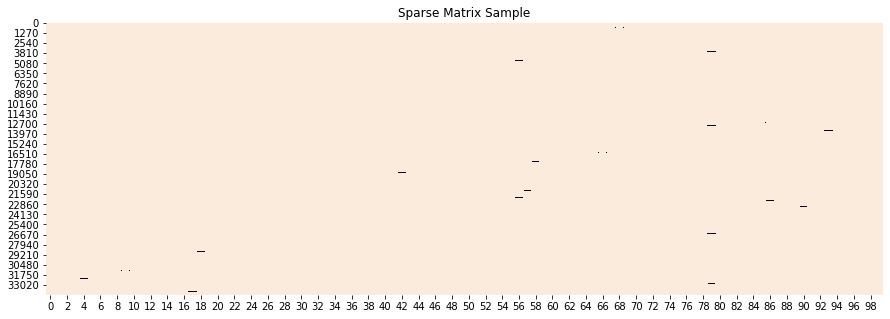

In [344]:
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vectorizer=vectorizer, vocabulary=None)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [345]:
# check some features
f_range = (500, 505)

print("fetures name (from dic_vocabulary):")
print({k:v for k,v in sorted(dic_vocabulary.items(), key=lambda item:item[1], reverse=False)
      if v in np.arange(f_range[0], f_range[1]+1, step=1)})

print("")
print("value of these features (in the sparse matrix) for the first text:")
print(vectorizer.get_feature_names()[f_range[0]:f_range[1]])
print(X_train[0, f_range[0]:f_range[1]].todense())

fetures name (from dic_vocabulary):
{'antitrump protest': 500, 'antitrump protester': 501, 'antitrump republican': 502, 'anton': 503, 'antonin': 504, 'antonin scalia': 505}

value of these features (in the sparse matrix) for the first text:
['antitrump protest', 'antitrump protester', 'antitrump republican', 'anton', 'antonin']
[[0. 0. 0. 0. 0.]]


In [346]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## list of token ids: [[1, 2, 3], ...]
len_tokens = len(lst_text2tokens[i])
print("to: ", lst_text2tokens[i], "| len:", len(lst_text2tokens[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

## words not in vocabulary?
if len_txt-len_tokens != 0:
    missing_words = [word for word in dtf_train["text_clean"].iloc[i].split() if word not in dic_vocabulary.keys()]
    print("!!!", len_txt-len_tokens, "words not in vocabulary:", missing_words)

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
to:  [8035, 4631, 4504, 60, 9884, 2118, 6109, 8089] | len: 8
check:  smith  -- idx in vocabulary --> 8035
!!! 2 words not in vocabulary: ['diplo', 'nicky']


###### Features Selection

In [348]:
X_names, dtf_selection = features_selection(X_train, dtf_train["y"], X_names, top=None, print_top=10)

features selection: from 10,000 to 3,152
 
# ENTERTAINMENT:
  . selected features: 2713
  . top features: actor, album, amy, award, bachelor, beyoncé, box office, celebrity, chrissy, clinton
 
# POLITICS:
  . selected features: 2775
  . top features: actor, apple, award, celebrity, clinton, dead, donald, donald trump, fan, film
 
# TECH:
  . selected features: 372
  . top features: amazon, android, app, apple, apple fbi, apps, artificial, artificial intelligence, battery, bitcoin
 


In [100]:
dtf_selection.sample(5)

feature     score              y
6490  pirate  0.995808       POLITICS
1043  blonde  0.995479  ENTERTAINMENT
5638   mitch  0.998220  ENTERTAINMENT
2234    deal  0.991033           TECH
5286   maker  0.998618           TECH

--- creating sparse matrix ---
shape: (34265, 2152)
--- used vocabulary ---
2152 words
--- tokenization ---
34265 texts


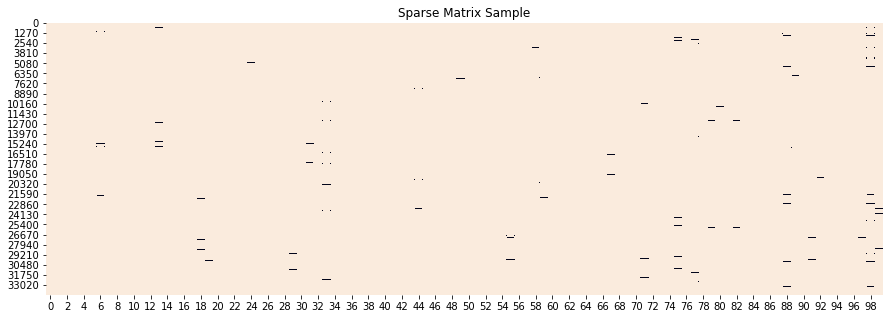

In [154]:
# Recreate Vectorizer with the selected vocabulary
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vocabulary=X_names)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [155]:
# Explore the sparse matrix as dtf
dtf_X_train = sparse2dtf(X_train, dic_vocabulary, X_names, prefix="")

In [156]:
dtf_X_train = pd.concat([dtf_train[["text","y"]], dtf_X_train.set_index(dtf_train.index)], axis=1)
dtf_X_train.head()

text              y  actor  \
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT    0.0   
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT    0.0   
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT    0.0   
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT    0.0   
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT    0.0   

   album  amy  award  bachelor  beyoncé  celebrity  chrissy  ...  belong  \
1    0.0  0.0    0.0       0.0      0.0        0.0      0.0  ...     0.0   
2    0.0  0.0    0.0       0.0      0.0        0.0      0.0  ...     0.0   
3    0.0  0.0    0.0       0.0      0.0        0.0      0.0  ...     0.0   
4    0.0  0.0    0.0       0.0      0.0        0.0      0.0  ...     0.0   
5    0.0  0.0    0.0       0.0      0.0        0.0      0.0  ...     0.0   

   reply  temporarily  organizer  germany  radically  hitting  flaw  \
1    0.0          0.0        0.0      0.0        0.0      0.0   0.0   
2    0.0          0.0        0.0      0.0        0.0      0.0   0.0   
3    0.0          0.0        0.0      0.0        0.0      0.0   0.0   
4    0.0          0.0        0.0      0.0        0.0      0.0   0.0   
5    0.0          0.0        0.0      0.0        0.0      0.0   0.0   

   registered  plug  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
5         0.0   0.0  

[5 rows x 2154 columns]

###### Model Design

In [157]:
classifier = naive_bayes.MultinomialNB()

###### Train / Test

In [158]:
# Take the raw text for X_test and will be transformed/predicted by the pipeline
X_test = dtf_test["text_clean"].values

In [159]:
model, predicted_prob, predicted = fit_ml_classif(X_train, y_train, X_test, vectorizer, classifier)

###### Evaluate

Accuracy: 0.85
Auc: 0.94
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.83      0.87      6439
     POLITICS       0.81      0.96      0.88      7179
         TECH       0.95      0.24      0.38      1067

     accuracy                           0.85     14685
    macro avg       0.89      0.68      0.71     14685
 weighted avg       0.86      0.85      0.84     14685



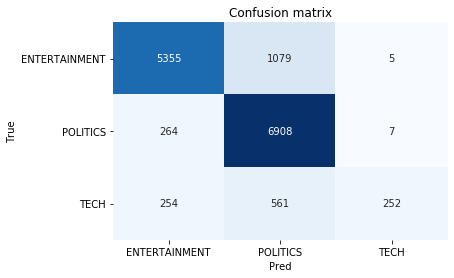

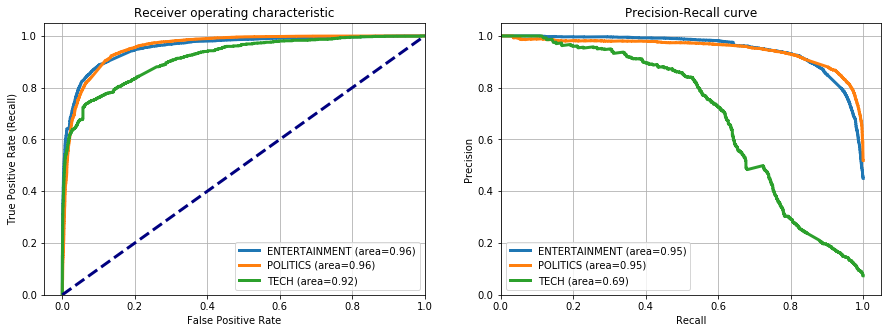

In [160]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [174]:
i = 9
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
exp = explainer_lime(model, y_train, txt_instance=dtf_test["text"].iloc[i], top=3)

True: POLITICS --> Pred: POLITICS | Prob: 0.97
 


### 4 - Model Desing & Testing (Embedding + Deep Learning)

###### Plan:
- Create common n-grams detectors
- Features Engineering with sequence padding
- Load/Train NLP
- Create Weights with word embedding
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Common n-grams detectors

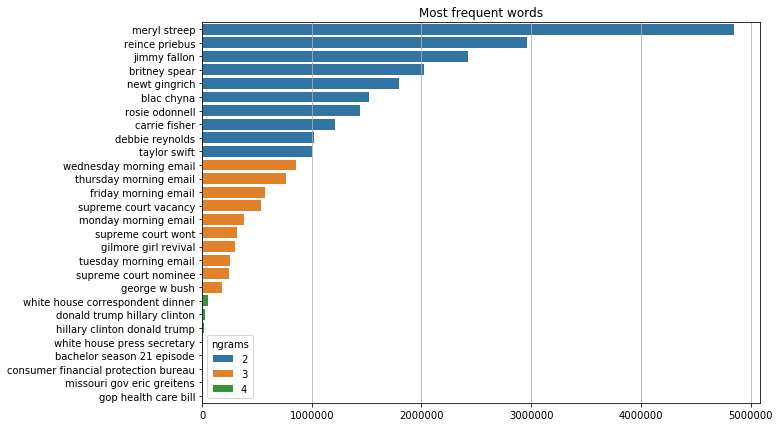

In [20]:
# not necessary, but useful
lst_common_terms = ["of","with","without","and","or","the","a"]

lst_ngrams_detectors, dtf_ngrams = create_ngrams_detectors(corpus=dtf_train["text_clean"], 
                                                           lst_common_terms=lst_common_terms, min_count=5, 
                                                           top=10, figsize=(10,7))

In [21]:
txt = "donald trump is on saturday night live from new york"
lst_ngrams_detectors[1][txt.split()]

['donald trump', 'is', 'on', 'saturday night', 'live', 'from', 'new', 'york']

In [179]:
dtf_ngrams.sample(5)

word          freq  ngrams
1211  house freedom caucus  1.374061e+03       3
380     sheriff joe arpaio  5.603594e+03       3
936          year marriage  3.020805e+01       2
1493        reince priebus  2.869040e+06       2
1677  donald trump finally  1.867865e+03       3

###### Features Engineering

--- tokenization ---
22348 words
--- padding to sequence ---
34291 sequences of length 15


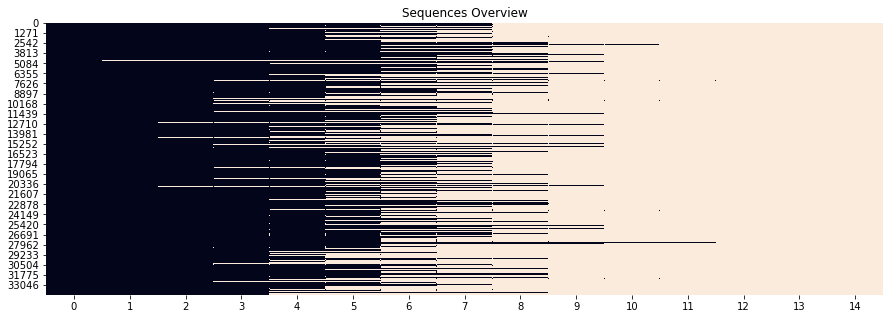

In [22]:
# create input for lstm (sequences of tokens)
dic_seq = text2seq(corpus=dtf_train["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors, 
                   top=None, oov="NaN", maxlen=15)

X_train, tokenizer, dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [181]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
to:  [ 611  332 8687 8688 4233  320   82 4620   68  445    0    0    0    0
    0] | len: 15
check:  smith  -- idx in vocabulary --> 611
vocabulary:  {'NaN': 1, 'trump': 2, 'donald trump': 3, 'new': 4, 'republican': 5} ... (padding element, 0)


--- tokenization ---
--- padding to sequence ---
14697 sequences of length 15


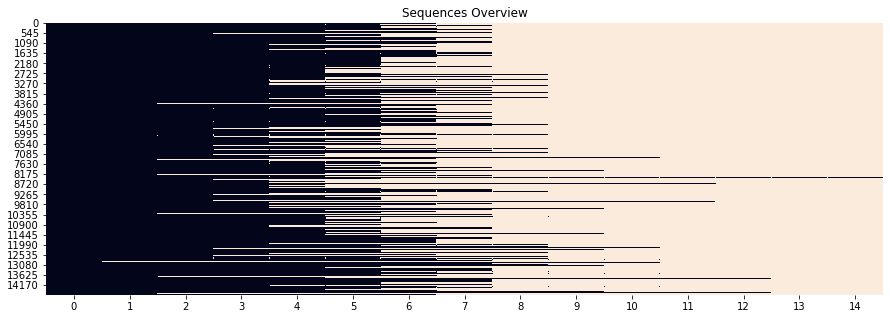

In [25]:
# Preprocess Test with the same tokenizer
X_test = text2seq(corpus=dtf_test["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors,
                  fitted_tokenizer=tokenizer, maxlen=X_train.shape[1])

###### Load/Train NLP

In [183]:
# Load pre-trained W2V
#nlp = gensim_api.load("glove-wiki-gigaword-300")

In [24]:
# Or train Word2Vec from scratch
avg_len = np.max([len(text.split()) for text in dtf_train["text_clean"]]) /2 

lst_corpus, nlp = fit_w2v(corpus=dtf_train["text_clean"], lst_ngrams_detectors=lst_ngrams_detectors,
                          min_count=1, size=300, window=avg_len, sg=0, epochs=30)

In [379]:
# check nlp model
word = "avenger infinity war"
nlp[word].shape

(300,)

<IPython.core.display.Javascript object>


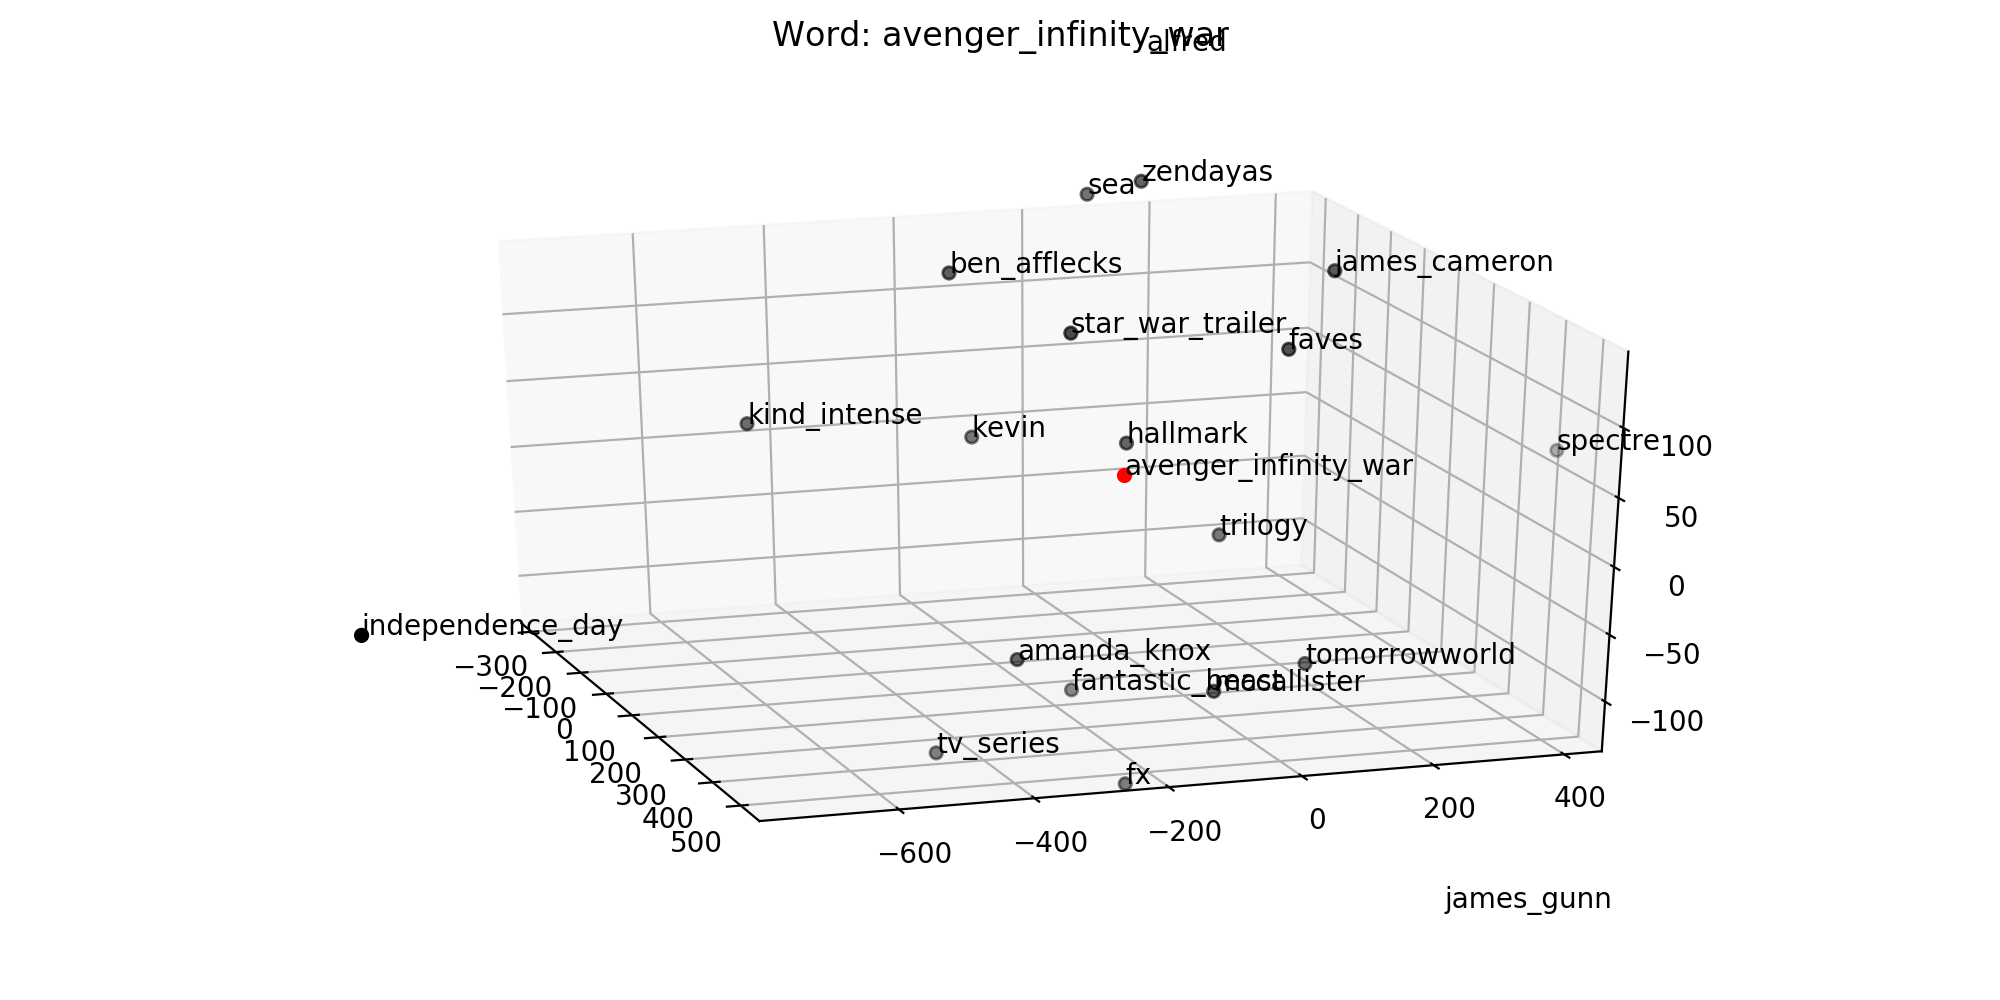

In [51]:
#%matplotlib notebook
plot_w2v(lst_words=[word], nlp=nlp, plot_type="3d", top=20, figsize=(10,5))

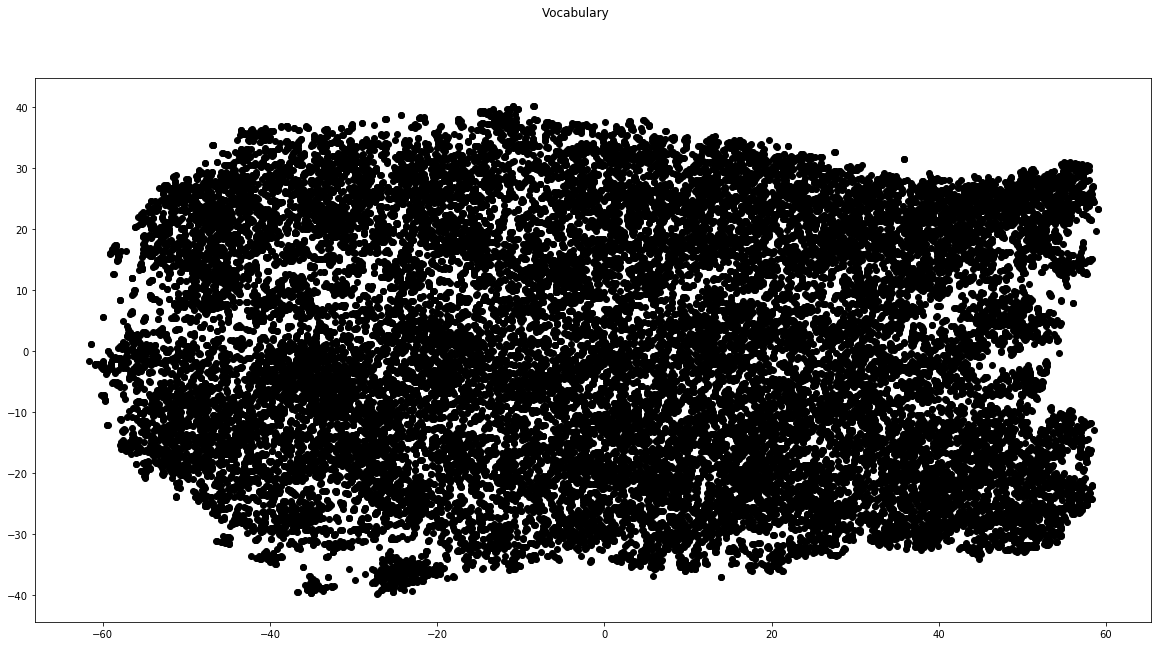

In [231]:
plot_w2v(lst_words=None, nlp=nlp, plot_type="2d", annotate=False, figsize=(20,10))

###### Create Weights

In [186]:
embeddings = vocabulary_embeddings(dic_vocabulary, nlp)

vocabulary mapped to 22338 vectors of size 300


In [187]:
# check
word = dtf_train["text_clean"].iloc[0].split()[0]
print("word:", word)
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

word: smith
dic[word]: 611 |idx
embeddings[idx]: (300,) |vector


In [188]:
# padding element
print("null vector:", 0)
embeddings[0]

null vector: 0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

###### Model Design

In [189]:
'''
Dot-Product Attention layer for DL models.
    softmax(Q x K) x V
:parameter
    :param x: tensor
    :param neurons: int - length of the sequences (X_train.shape[1])
'''
def attention_layer(x, neurons):
    Q, K, V = x, x, x
    K = layers.Permute((2,1))(K)
    QxK = layers.Dense(neurons, activation="softmax")(K)
    QxK = layers.Permute((2,1), name="attention")(QxK)
    x = layers.multiply([V, QxK])
    return x

In [190]:
# Embedding network with Bi-LSTM and Attention layers (for attention explainer)

x_in = layers.Input(shape=(X_train.shape[1],))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
                     input_length=X_train.shape[1], trainable=False)(x_in)
## attention
#x = attention_layer(x, neurons=X_train.shape[1])  #<-- tensorflow 1 (manual function)
x = layers.Attention()([x,x])                      #<-- tensorflow 2 (included in keras)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=X_train.shape[1], dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=X_train.shape[1], dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 300)      6701400     input_3[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 300, 15)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 300, 15)      240         permute_2[0][0]                  
__________________________________________________________________________________________________
attention 

In [191]:
# Binary version without attention (shap explainer only works with this)

#y_train = pd.get_dummies(dtf_train["y"], drop_first=False).values

#model = models.Sequential([
#    layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
#                     input_length=X_train.shape[1], trainable=False),
#    layers.LSTM(units=X_train.shape[1], dropout=0.2),
#    layers.Dense(3, activation='sigmoid')
#])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

#training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=10, shuffle=True, verbose=0, validation_split=0.3)
#utils_plot_keras_training(training)
#predicted_prob = model.predict(X_test)
#predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

###### Train / Test

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


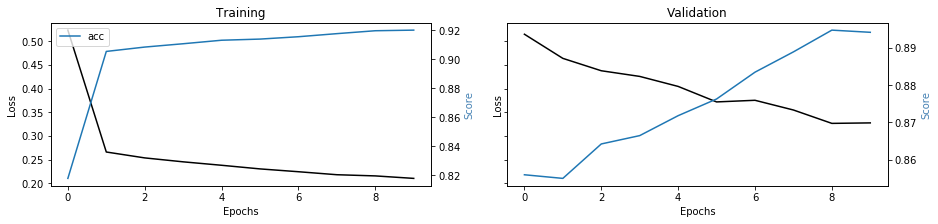

In [192]:
# this takes a while
model, predicted_prob, predicted = fit_dl_classif(X_train, y_train, X_test, encode_y=True, 
                                                  model=model, epochs=10, batch_size=256)

###### Evaluate

Accuracy: 0.84
Auc: 0.92
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.88      0.83      0.85      6439
     POLITICS       0.81      0.94      0.87      7179
         TECH       0.93      0.24      0.38      1067

     accuracy                           0.84     14685
    macro avg       0.87      0.67      0.70     14685
 weighted avg       0.85      0.84      0.83     14685



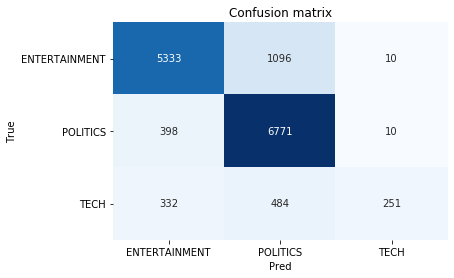

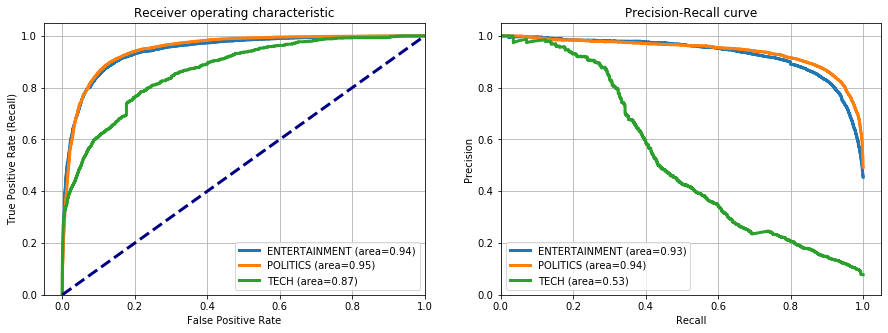

In [193]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

True: POLITICS --> Pred: POLITICS | Prob: 1.0
 


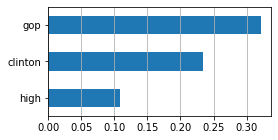

Text with highlighted words


In [319]:
i = 9
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
text_exp = explainer_attention(model, tokenizer, dtf_test["text"].iloc[i], lst_ngrams_detectors, top=3, figsize=(4,2))

print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text_exp))

### 5 - Model Desing & Testing (Language model + Transfer Learning)

###### Plan:
- Features Engineering
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [24]:
# Load pre-trained BERT tokenizer
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
#lst_vocabulary = list(tokenizer.vocab.keys())

In [5]:
# Load pre-trained BERT tokenizer (use a lighter veriosn: distil-BERT)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
lst_vocabulary = list(tokenizer.vocab.keys())

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [26]:
# check nlp model
txt = "river bank"
X = embedding_bert(txt, tokenizer, nlp, log=True)
print("shape:", X.shape)
print("mean:", np.mean(X[1]))

tokens: ['[CLS]', 'river', 'bank', '[SEP]']
ids   : [101, 2314, 2924, 102]
shape: (2, 768)
mean: -0.008974858


In [33]:
X_train = tokenize_bert(corpus=dtf_train["text"], tokenizer=tokenizer, maxlen=50)

maxlen: 50
created tensor idx-masks-segments: 3x (35615, 50)


In [34]:
# check feature creation
i = 0

print("txt: ", dtf_train["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

txt:  Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
tokenized: ['[CLS]', 'will', 'smith', 'joins', 'dip', '##lo', 'and', 'nicky', 'jam', 'for', 'the', '2018', 'world', 'cups', 'official', 'song', '[SEP]', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
idx:  [  101  2097  3044  9794 16510  4135  1998 20158  9389  2005  1996  2760
  2088 10268  2880  2299   102   100     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
segment:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

In [85]:
X_test = tokenize_bert(corpus=dtf_test["text"], tokenizer=tokenizer, maxlen=50)

maxlen: 50
created tensor idx-masks-segments: 3x (14687, 50)


###### Model Design

In [79]:
# Pre-trained BERT + fine-tuning (transfer learning)

## inputs
#idx = layers.Input((50), dtype="int32", name="input_idx")
#masks = layers.Input((50), dtype="int32", name="input_masks")
#segments = layers.Input((50), dtype="int32", name="input_segments")
## pre-trained bert
#bert = transformers.TFBertModel.from_pretrained("bert-base-uncased")
#bert_out, _ = bert([idx, masks, segments])
## fine-tuning
#x = layers.GlobalAveragePooling1D()(bert_out)
#x = layers.Dense(64, activation="relu")(x)
#y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
#model = models.Model([idx, masks, segments], y_out)
#for layer in model.layers[:4]:
#    layer.trainable = False
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_5 (TFBertModel)   ((None, 50, 768), (N 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]         

In [86]:
# Pre-trained distil-BERT + fine-tuning (transfer learning)

## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_12 (TFDist ((None, 50, 768),)   66362880    input_idx[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d_13 (Gl (None, 768)          0           tf_distil_bert_model_12[0][0]    
___________________________________________________________________________________________

###### Train / Test

In [87]:
# this takes a while
model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                    model=model, epochs=1, batch_size=64)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}
Train on 23986 samples, validate on 10281 samples
23986/23986 [==============================] - 3976s 166ms/sample - loss: 0.2501 - accuracy: 0.9051 - val_loss: 0.2951 - val_accuracy: 0.8983


###### Evaluate

Accuracy: 0.86
Auc: 0.96
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.86      0.88      6433
     POLITICS       0.83      0.96      0.89      7185
         TECH       0.95      0.28      0.43      1069

     accuracy                           0.86     14687
    macro avg       0.90      0.70      0.73     14687
 weighted avg       0.87      0.86      0.85     14687



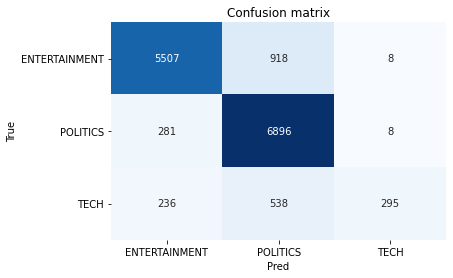

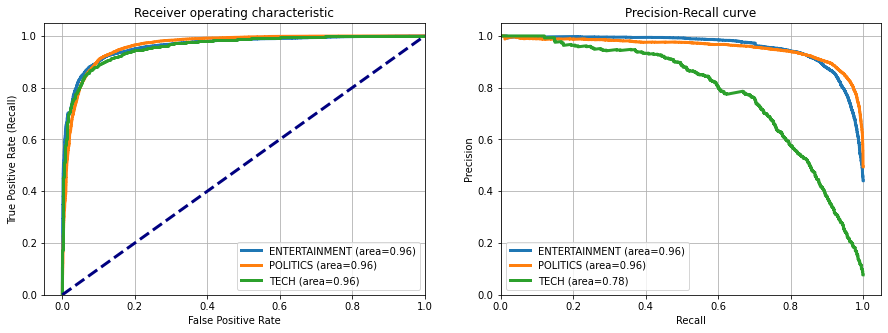

In [88]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

### 6 - Model Desing & Testing (Clustering by Similarity)

###### Plan:
- Create Target Clusters: Define keywords for each class using W2V
- Features Engineering: embedding X and y with BERT
- Model Design & Testing: Assign cluster using Cosine Similarity
- Evaluate
- Explainability

######  Create Target Clusters

In [2]:
# Load pre-trained W2V
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [630]:
# Strategy 1) From the feature selection in BoW ...
dtf_selection.sample(3)

feature     score              y
5556   might  0.999921           TECH
2375    dems  0.994426       POLITICS
7113  repeal  0.999995  ENTERTAINMENT

In [693]:
dic_clusters = {}
for y in np.unique(y_train):
    dic_clusters[y] = [word for word in dtf_selection[dtf_selection["y"]==y]["feature"].tolist() if nlp.vocab.get(word)]

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ENTERTAINMENT :  ['actor', 'album', 'amy', 'award', 'bachelor'] ... 2251
POLITICS :  ['actor', 'apple', 'award', 'celebrity', 'clinton'] ... 2299
TECH :  ['amazon', 'android', 'app', 'apple', 'apps'] ... 344


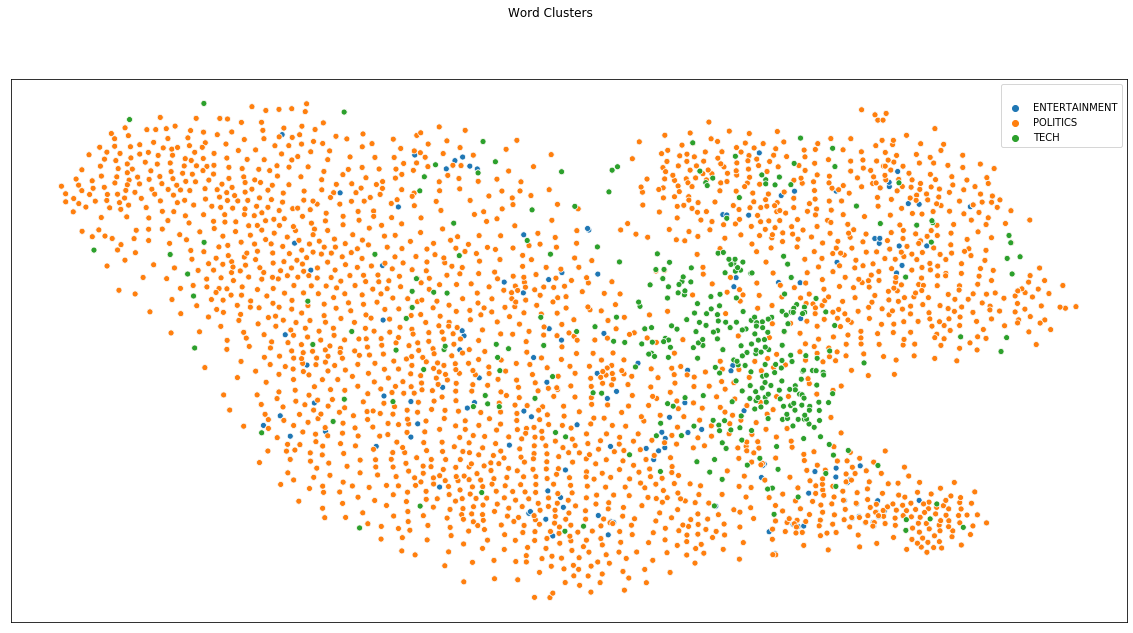

In [694]:
plot_w2v_cluster(dic_clusters, nlp, plot_type="2d", annotate=False, figsize=(20,10))

In [695]:
#-> It's no good, they are not specific, POLITICS is pretty much everywhere.

# ENTERTAINMENT:
--- training ---


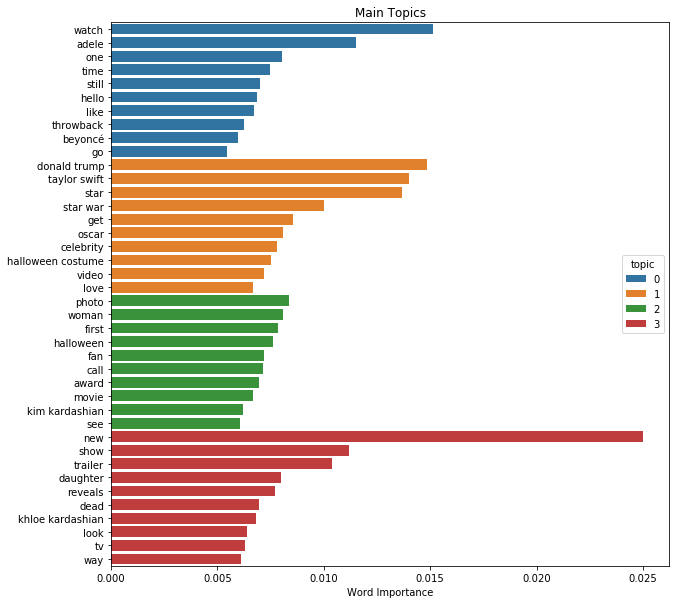

 
# POLITICS:
--- training ---


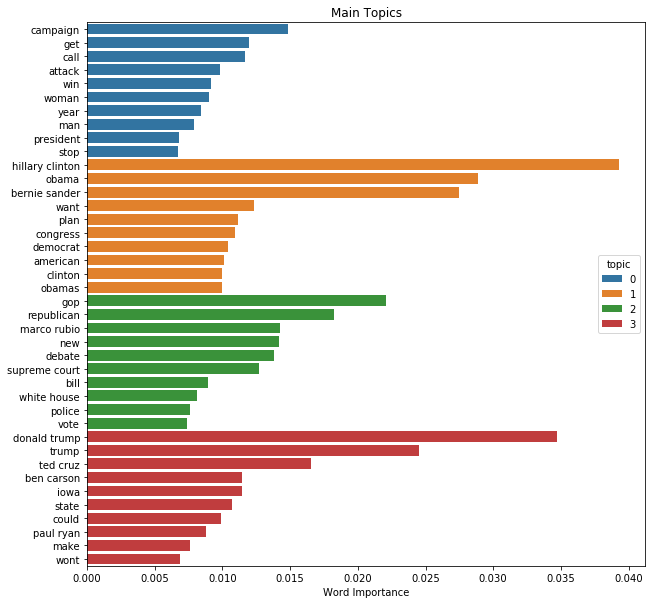

 
# TECH:
--- training ---


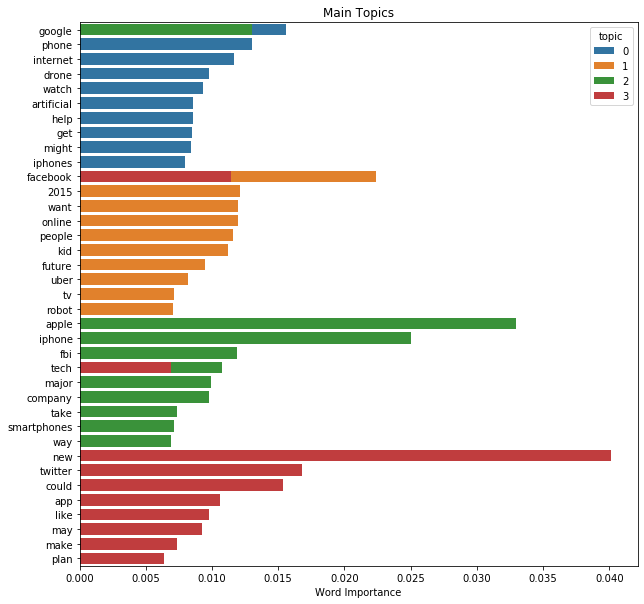

In [696]:
# Strategy 2) LDA for topic modeling
dtf_topics = pd.DataFrame()
for y in dtf_train["y"].unique():
    print("# {}:".format(y))
    lda, dtf_y = fit_lda(corpus=dtf_train[dtf_train["y"]==y]["text_clean"], n_topics=4, 
                         lst_ngrams_detectors=lst_ngrams_detectors, figsize=(10,10))
    dtf_y["y"] = y
    dtf_topics = dtf_topics.append(dtf_y)
    print(" ")

In [697]:
dtf_topics.sample(5)

topic    id        word    weight              y
5       0  1946  artificial  0.008581           TECH
32      3   495     trailer  0.010391  ENTERTAINMENT
19      1   472        love  0.006674  ENTERTAINMENT
16      1   382      future  0.009449           TECH
9       0   405        stop  0.006703       POLITICS

In [702]:
dic_clusters = {y:dtf_topics[dtf_topics["y"]==y]["word"].values.tolist() for y in dtf_topics["y"].unique()}

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ENTERTAINMENT :  ['watch', 'adele', 'one', 'time', 'still'] ... 40
POLITICS :  ['campaign', 'get', 'call', 'attack', 'win'] ... 40
TECH :  ['google', 'phone', 'internet', 'drone', 'watch'] ... 40


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


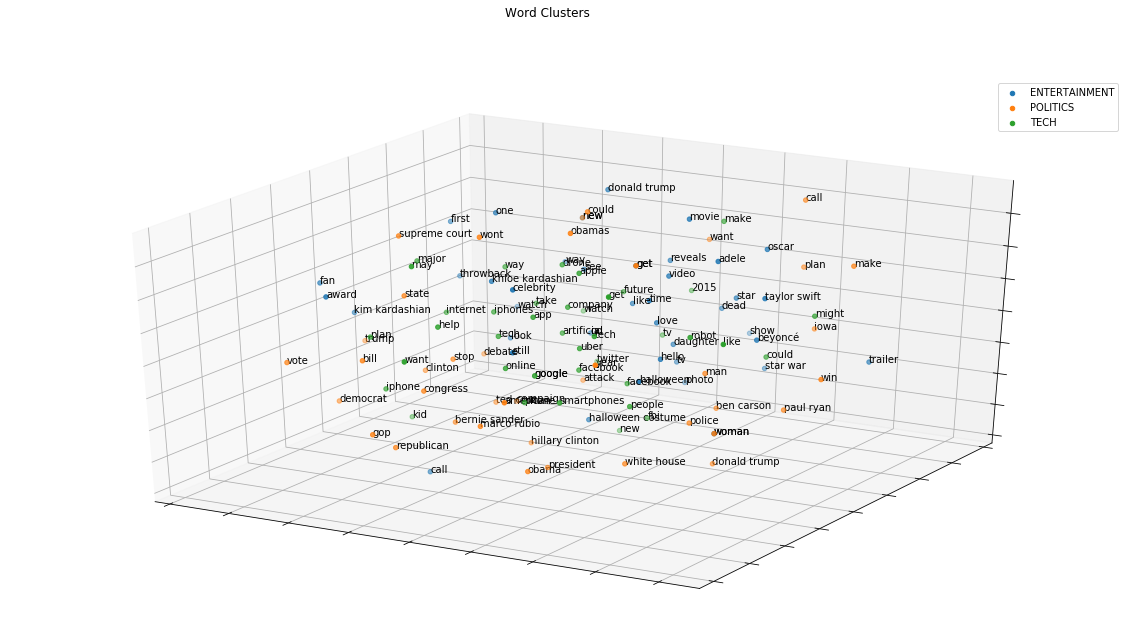

In [704]:
#%matplotlib notebook
plot_w2v_cluster(dic_clusters, nlp, plot_type="3d", annotate=True, figsize=(20,10))

In [ ]:
#-> Still not good.

In [5]:
# Strategy 3) using NLP to get smilar words from manual inputs
nlp.most_similar(["obama"], topn=3)

[('barack', 0.9254721403121948),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570987939834595)]

In [3]:
dic_clusters = {}
dic_clusters["ENTERTAINMENT"] = get_similar_words(['celebrity','cinema','movie','music'], top=30, nlp=nlp)
dic_clusters["POLITICS"] = get_similar_words(['gop','clinton','president','obama','republican'], top=30, nlp=nlp)
dic_clusters["TECH"] = get_similar_words(['amazon','android','app','apple','facebook','google','tech'], top=30, nlp=nlp)

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ENTERTAINMENT :  ['movie', 'audiences', 'movies', 'theatrical', 'concert'] ... 34
POLITICS :  ['election', 'democrat', 'kerry', 'presidential', 'rodham'] ... 35
TECH :  ['download', 'amazon', 'netscape', 'messaging', 'intel'] ... 37


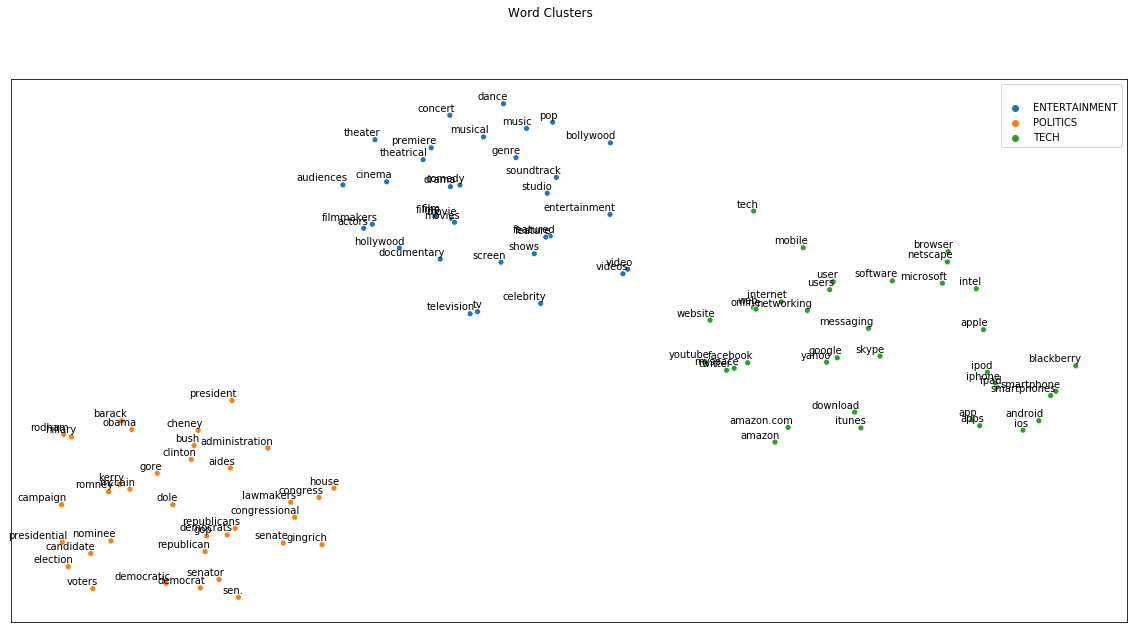

In [4]:
plot_w2v_cluster(dic_clusters, nlp, plot_type="2d", annotate=True, figsize=(20,10))

In [ ]:
#-> Much better, they are separated from each other.

##### Features Engineering

In [6]:
# Load pre-trained BERT tokenizer (use a lighter veriosn: distil-BERT)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
lst_vocabulary = list(tokenizer.vocab.keys())

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [190]:
# Create X (Unsupervised, so no need to use dtf_train)
X_test = embedding_bert(dtf_test["text_clean"], tokenizer, nlp)
X_test.shape

(14689, 768)

In [196]:
# Create y as {label:mean_vector}
dic_y = {k:embedding_bert(v, tokenizer, nlp).mean(0) for k,v in dic_clusters.items()}
dic_y["ENTERTAINMENT"].shape

(768,)

###### Model Design & Testing

In [293]:
predicted_prob, predicted = predict_similarity_classif(X_test, dic_y)

###### Evaluate

Accuracy: 0.64
Auc: 0.88
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.56      0.97      0.71      6432
     POLITICS       0.94      0.40      0.56      7184
         TECH       0.80      0.30      0.44      1073

     accuracy                           0.64     14689
    macro avg       0.76      0.56      0.57     14689
 weighted avg       0.76      0.64      0.62     14689



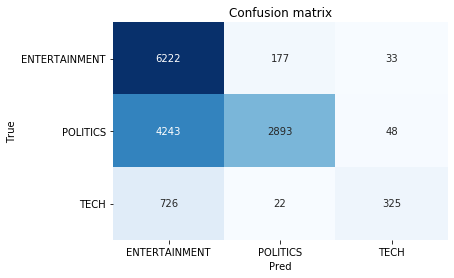

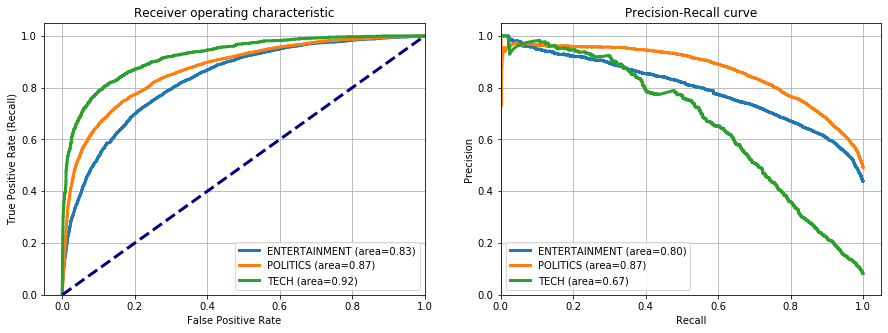

In [192]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

True: POLITICS --> Pred: POLITICS | Similarity: 0.37
 
republican fail take hillary clinton 11hour benghazi hearing


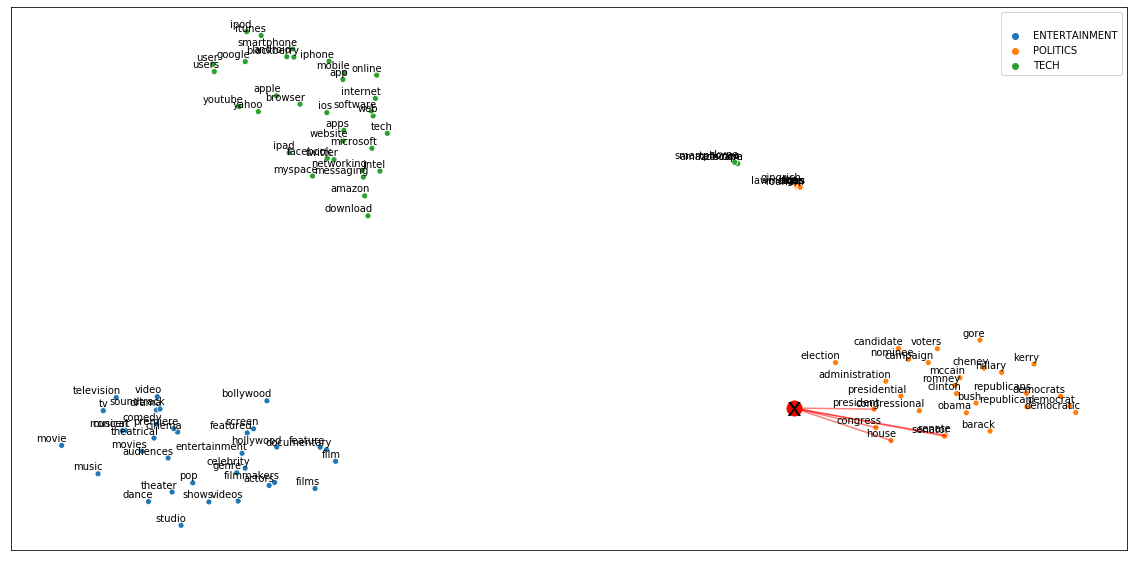

In [477]:
i = 7
print("True:", y_test[i], "--> Pred:", predicted[i], "| Similarity:", round(np.max(predicted_prob[i]),2))
print(" ")
print(dtf_test["text_clean"].iloc[i])
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf_test["text_clean"].iloc[i], 
                             token_level=False, top=5, figsize=(20,10))

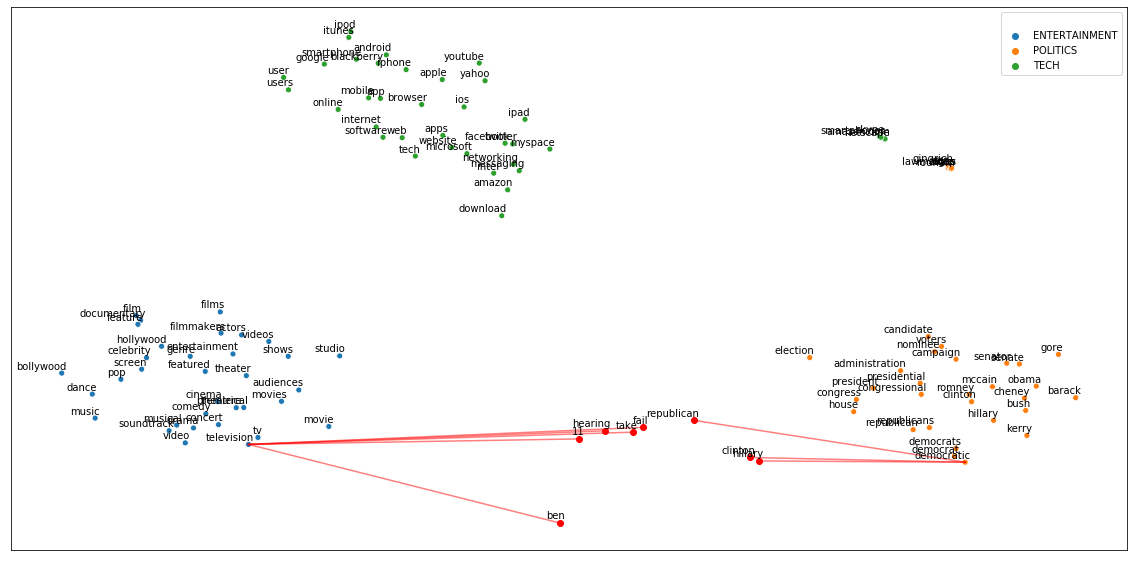

In [471]:
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf_test["text_clean"].iloc[i], 
                             token_level=True, top=1, figsize=(20,10))